In [75]:
import pickle
import random
import pandas as pd
import sympy as sp
from scipy.integrate import solve_ivp
import os
import json
import numpy as np
from scipy.spatial import KDTree


with open(r'D:\ucl\pyssem\scenario-properties.pkl', 'rb') as file:
    scenario_properties = pickle.load(file)

t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
t: 36.53653653653654, t_normalized: 36.53653653653654, t_index_floor: 36, t_index_ceil: 37
date_floor: 2057-12, date_ceil: 2058-12
t: 73.07307307307308, t_normalized: 73.07307307307308, t_index_floor: 73, t_index_ceil: 74
date_floor: 2094-12, date_ceil: 2095-12
t: 109.6096096096096, t_normalized: 100, t_index_floor: 100, t_index_ceil: 100
date_floor: 2121-12, date_ceil: 2121-12
t: 146.14614614614615, t_normalized: 100, t_index_floor: 100, t_index_ceil: 100
date_floor: 2121-12, date_ceil: 2121-12
t: 182.6826826826827, t_normalized: 100, t_index_floor: 100, t_index_ceil: 100
date_floor: 2121-12, date_ceil: 2121-12
t: 219.2192192192192, t_normalized: 100, t_index_floor: 100, t_index_ceil: 100
date_floor: 2121-12, date_ceil: 2121-12
t: 255.75575575575576, t_normalized: 100, t_index_floor: 100, t_index_ceil: 100
date_floor: 2121-12, date_ceil: 2121-12
t: 292.2922922922923, t_normalized: 100,

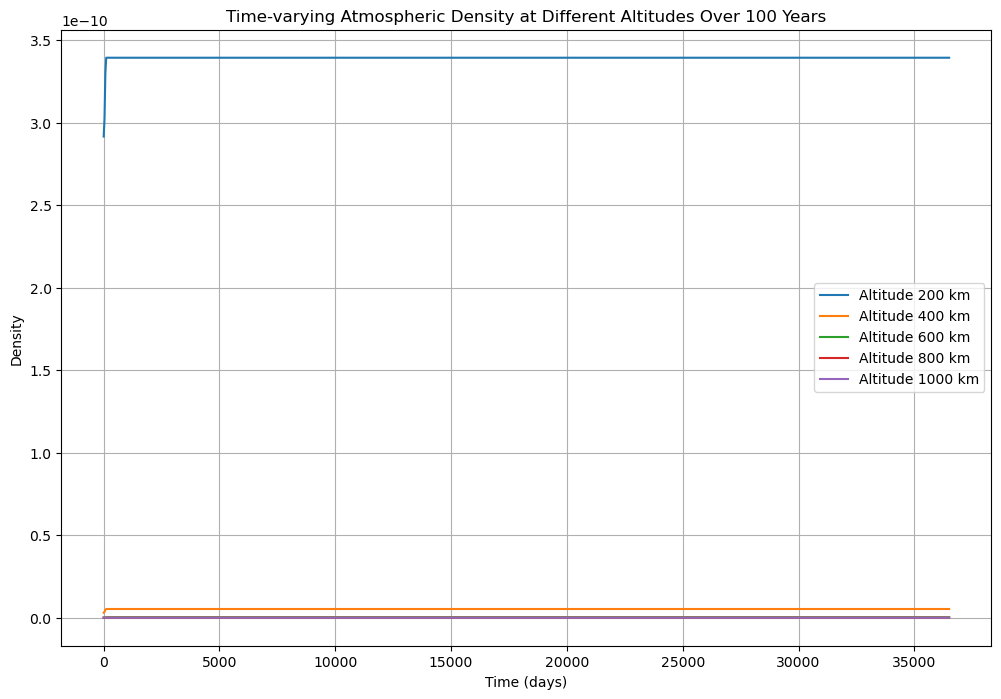

In [ ]:
def preload_density_data(file_path):
    with open(file_path, 'r') as file:
        density_data = json.load(file)
    return density_data

# Function to precompute date mapping for given time range
def precompute_date_mapping(start_date, end_date, num_points=101):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    total_days = (end_date - start_date).days
    dates = [start_date + pd.to_timedelta(i / (num_points - 1) * total_days, unit='d') for i in range(num_points)]
    date_mapping = [date.strftime('%Y-%m') for date in dates]
    return date_mapping

# Function to precompute nearest altitude mapping using KDTree for efficient lookup
def precompute_nearest_altitudes(available_altitudes, max_query=2000, resolution=1):
    altitude_tree = KDTree(np.array(available_altitudes).reshape(-1, 1))
    altitude_mapping = {}
    for alt in range(0, max_query + resolution, resolution):
        _, idx = altitude_tree.query([[alt]])
        nearest_alt = available_altitudes[idx[0]]
        altitude_mapping[alt] = nearest_alt
    return altitude_mapping

# Function to calculate atmospheric density using precomputed data
def JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping):
    """
    Calculate density at various altitudes based on a percentage through a time range
    using precomputed data for efficiency.

    :param t: Percentage of the way through the simulation (0-100).
    :param h: List of altitudes for which densities are required.
    :param density_data: Preloaded density data.
    :param date_mapping: Precomputed date mapping.
    :param nearest_altitude_mapping: Precomputed nearest altitude mapping.
    :return: List of densities corresponding to each altitude in h.
    """
    num_dates = len(date_mapping)
    t_normalized = min(max(t / 100 * (num_dates - 1), 0), num_dates - 1)
    
    # Find the two nearest indices and their corresponding dates
    t_index_floor = int(np.floor(t_normalized))
    t_index_ceil = int(np.ceil(t_normalized))

    if t_index_ceil >= num_dates:
        t_index_ceil = num_dates - 1

    date_floor = date_mapping[t_index_floor]
    date_ceil = date_mapping[t_index_ceil]

    print(f"t: {t}, t_normalized: {t_normalized}, t_index_floor: {t_index_floor}, t_index_ceil: {t_index_ceil}")
    print(f"date_floor: {date_floor}, date_ceil: {date_ceil}")

    # Interpolation weight
    if t_index_floor == t_index_ceil:
        weight = 1
    else:
        weight = (t_normalized - t_index_floor) / (t_index_ceil - t_index_floor)

    # Get density values for the floor and ceil dates
    density_values_floor = []
    density_values_ceil = []

    for alt in h:
        query_alt = min(alt, max(nearest_altitude_mapping.keys()))
        nearest_alt = nearest_altitude_mapping[query_alt]

        try:
            density_floor = density_data[date_floor][str(nearest_alt)]
            density_ceil = density_data[date_ceil][str(nearest_alt)]
        except KeyError as e:
            print(f"KeyError: {e} for date_floor: {date_floor}, date_ceil: {date_ceil}, nearest_alt: {nearest_alt}")
            return None

        density_values_floor.append(density_floor)
        density_values_ceil.append(density_ceil)

    # Ensure that the interpolated values correctly capture the cyclical variations
    density_values_floor = np.array(density_values_floor)
    density_values_ceil = np.array(density_values_ceil)
    
    density_values = density_values_floor * (1 - weight) + density_values_ceil * weight

    return density_values


dstart_date_dt = pd.to_datetime(scenario_properties.start_date)
start_date_dt = pd.to_datetime(scenario_properties.start_date)

density_data = preload_density_data(r'D:\ucl\pyssem\pyssem\utils\drag\dens_highvar_2000_dens_highvar_2000_lookup.json')

# Precompute date mapping and nearest altitude mapping
date_mapping = precompute_date_mapping(start_date_dt, start_date_dt + pd.to_timedelta(scenario_properties.simulation_duration * 365, unit='d'))
available_altitudes = list(map(int, list(density_data['2020-03'].keys())))
available_altitudes.sort()
nearest_altitude_mapping = precompute_nearest_altitudes(available_altitudes)

# Define altitudes and time range for the plot
altitudes = [200, 400, 600, 800, 1000]  # Example altitudes in km
time_range = np.linspace(0, 365 * 100, 1000)  # 100 years, 500 points

# Collect density data over time
density_over_time = {alt: [] for alt in altitudes}

for t in time_range:
    densities = JB2008_dens_func(t, altitudes, density_data, date_mapping, nearest_altitude_mapping)
    if densities is None:
        continue  # Skip this iteration if there's an error
    for alt, density in zip(altitudes, densities):
        density_over_time[alt].append(density)

import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(12, 8))
for alt in altitudes:
    plt.plot(time_range, density_over_time[alt], label=f'Altitude {alt} km')

plt.xlabel('Time (days)')
plt.ylabel('Density')
plt.title('Time-varying Atmospheric Density at Different Altitudes Over 100 Years')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_upper_flattened = [scenario_properties.drag_term_upper[i, j] for j in range(scenario_properties.drag_term_upper.cols) for i in range(scenario_properties.drag_term_upper.rows)]
drag_current_flattened = [scenario_properties.drag_term_cur[i, j] for j in range(scenario_properties.drag_term_cur.cols) for i in range(scenario_properties.drag_term_cur.rows)]

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
drag_upper_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_upper_flattened]
drag_cur_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_current_flattened]

full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [ ]:
scenario_properties.time_dep_density = True

In [ ]:
x0_flattened = scenario_properties.x0.T.values.flatten()

rho_vals = []
time_vals = []

def population_shell(t, N, full_lambda, equations, times):
    print(f"Time: {t}")
    dN_dt = np.zeros_like(N)
    
    if scenario_properties.time_dep_density:
        # Get density values for the current time step
        rho = JB2008_dens_func(t, scenario_properties.R0_km, density_data, date_mapping, nearest_altitude_mapping)
        # print(f"Density at time {t}: {rho}")

        # Add the 10th value of rho to rho_vals for plotting
        rho_vals.append(rho[3])
        time_vals.append(t)
        
        # Extend rho for each species within each shell
        rho_full = np.repeat(rho, scenario_properties.species_length)

        num_shells = len(rho)
        species_per_shell = scenario_properties.species_length
        
        for i in range(len(N)):
            shell_index = i // species_per_shell
            species_index = i % species_per_shell
            
            current_drag = drag_cur_lamd[i](*N) * rho_full[shell_index]
            upper_drag = drag_upper_lamd[i](*N) * rho_full[shell_index + 1] if shell_index < num_shells - 1 else 0
            
            # print(f"Index: {i}, Shell: {shell_index}, Species: {species_index}, Rho: {rho_full[shell_index]}")
            # print(f"Current drag: {current_drag}, Upper drag: {upper_drag}")
            
            dN_dt[i] += current_drag
            if shell_index < num_shells - 1:
                dN_dt[i] += upper_drag

            if full_lambda[i] is not None:
                increase = np.interp(t, times, full_lambda[i])
                dN_dt[i] += 0 if np.isnan(increase) else increase

            dN_dt[i] += equations[i](*N)

    return dN_dt


output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, equations, scenario_properties.scen_times), 
                    t_eval=scenario_properties.scen_times, method='BDF')

Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 1.945878695319591e-06
t: 1.945878695319591e-06, t_normalized: 1.945878695319591e-06, t_index_floor: 0, t_index_ceil: 1
date_floor: 2022-01, date_ceil: 2023-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_index_ceil: 0
date_floor: 2022-01, date_ceil: 2022-01
Time: 0.0
t: 0.0, t_normalized: 0.0, t_index_floor: 0, t_i

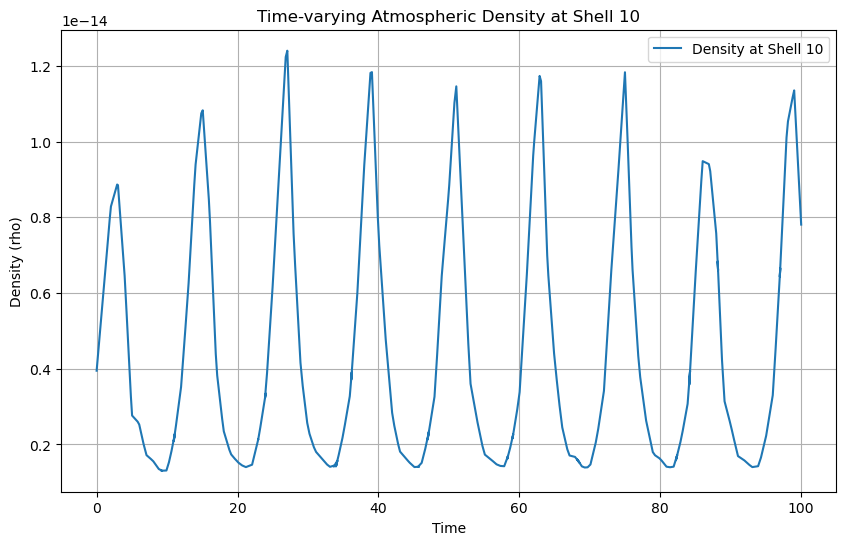

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time_vals, rho_vals, label='Density at Shell 10')
plt.xlabel('Time')
plt.ylabel('Density (rho)')
plt.title('Time-varying Atmospheric Density at Shell 10')
plt.legend()
plt.grid(True)
plt.show()

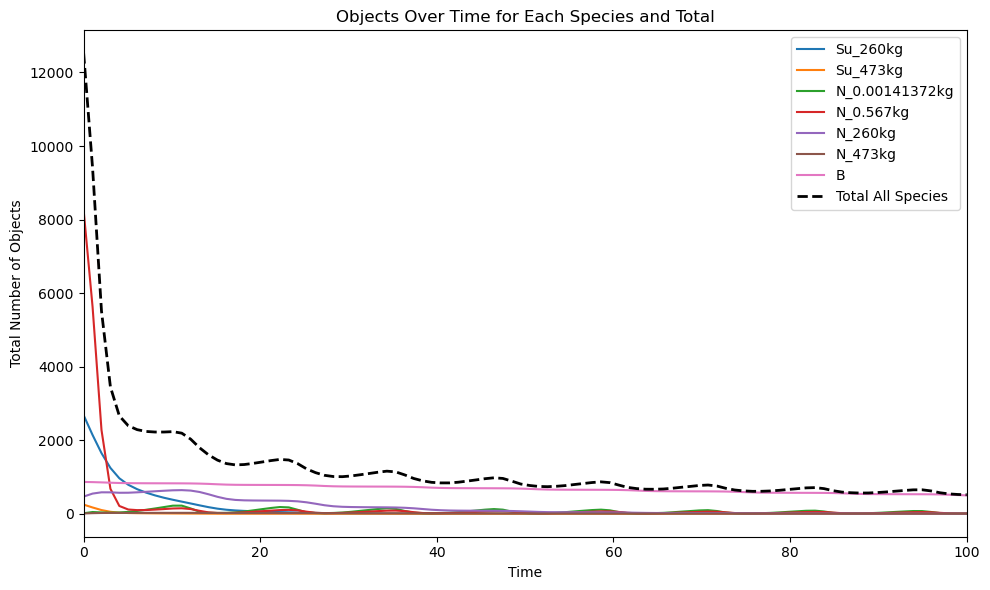

In [ ]:
# Assuming scenario_properties.species_names is available
import matplotlib.pyplot as plt # type: ignore
species_names = scenario_properties.species_names
# output = scenario_properties.output

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = scenario_properties.species_length
num_shells = scenario_properties.n_shells

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))


plt.legend()
plt.tight_layout()
plt.show()